In [1]:
import os
import re

import numpy as np
import torch
import tqdm

### 定义几个辅助函数：
↓👇以下是两个表：单词->单词序号；单词序号->词向量。


word2index：把单词转成索引，索引可以找到词向量

In [2]:
word_list = []
vocabulary_vectors = []
# glove_data = open('data/glove.6B.50d.txt', encoding='utf-8')
#大家都用100d
glove_data = open('data/glove.6B.100d.txt', encoding='utf-8') # 我下下来的glove是100d，yyt你要用的话记得改回上一行（）
for line in glove_data.readlines():
    temp = line.strip('\n').split(' ')  # 一个列表
    name = temp[0]
    word_list.append(name.lower())
    vector = [temp[i] for i in range(1, len(temp))]  # 向量
    vector = list(map(float, vector))  # 变成浮点数
    vocabulary_vectors.append(vector)
# 保存
vocabulary_vectors = np.array(vocabulary_vectors)
word_list = np.array(word_list)
np.save('npys/vocabulary_vectors', vocabulary_vectors)
np.save('npys/word_list', word_list)
#保存你🐎呢，马上就用了
#笨笨
word_list = np.load('npys/word_list.npy', allow_pickle=True)

# 直接tm给你转成哈希表，傻子才用list一个一个搜索呢，堪称头部螺旋桨
word_list = word_list.tolist()
word2index={} # word->index
for i in range(len(word_list)):
    word2index[word_list[i]]=i

↓👇这个用来从文件中加载原始文本数据并处理成单词列表

In [3]:
def load_data(path, flag='train'):
    labels = ['pos', 'neg']
    data = []
    r = '[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n。！，]+'
    compiled = re.compile(r)
    for label in labels:
        files = os.listdir(os.path.join(path, flag, label))
        for file in tqdm.tqdm(files): # Don't be nervous, tqdm is only a progress bar. 
            with open(os.path.join(path, flag, label, file), 'r', encoding='utf8') as rf:
                temp = rf.read()
                temp = temp.replace('\n', ' ').replace('<br /><br />', ' ')
                #在标点符号左右加空格，为了让标点也独立成为单词
                temp = re.sub(r, ' \g<0> ', temp)
                temp = temp.split(' ')
                temp = [temp[i].lower() for i in range(len(temp)) if temp[i] != '']
                if label == 'pos':
                    data.append([temp, 1])
                elif label == 'neg':
                    data.append([temp, 0])
            #break # Remember to delete this
    return data

↓👇这个用来把所有文本转成numpy数组，然后存在文件里。至此，预处理完成。

In [4]:
SENTENCE_MAXLEN=600
def process_sentence(flag: str, path: str = 'data/aclImdb', length_limit: int = SENTENCE_MAXLEN):
    '''Process data into numpy arrays and save them. 
    ---
    They look like: 
    
    sentence_code: [[word IDs], [word IDs], ...]
    
    labels: [label, label, ...]
    
    flag should be either "train" or "test". 
    '''
    output_dir = os.path.join("./npys", flag)
    os.makedirs(output_dir, exist_ok=True)
    # if os.path.exists(os.path.join(output_dir, "sentence_code.npy")) and os.path.exists(os.path.join(output_dir, "labels.npy")):
    #     print("大哥，你已经预处理过了🤣")
    #     return []
    
    sentence_code = []
    labels = []
    reallen=[]
    length=[0 for i in range(2000)] # 统计评论长度分布
    test_data = load_data(path, flag)
   
    for i in tqdm.tqdm(range(len(test_data))): # Don't be nervous, tqdm is only a progress bar. 
        # nb
        # print(i)
        vec = test_data[i][0]
        label = test_data[i][1] # 0 or 1 0 means neg 1 means positive
        temp = []
        index = 0
        for j in range(len(vec)):
            try:
                index = word2index[vec[j]]
            except KeyError:  # 没找到
                index = -1 #400000 在 glove6B里是 <unk>的 index #两个glove还不一样 无语 都变成-1好了
            finally:
                temp.append(index)  # temp表示一个单词在词典中的序号
        
        # 统计评论长度分布
        l=len(temp)
        if(l<10):
            print(vec,label)
        reallen.append(l)
        
        if l>=2000:
            l=1999
        length[l]+=1
        

        if l<length_limit:
            for k in range(l, SENTENCE_MAXLEN):  # 不能补 0 因为 0 是 the 的 index 这里补 -1 转换成词向量时特殊处理
                temp.append(-1)
        else:
            temp = temp[0:SENTENCE_MAXLEN]  # 只保留250个
        sentence_code.append(temp)
        labels.append(label)
     

    sentence_code = np.array(sentence_code,dtype=object)
    np.save(os.path.join(output_dir, "sentence_code"), sentence_code)
    np.save(os.path.join(output_dir, "labels"), labels)
    return length,reallen


测试一下，看看数据发育正不正常啊

In [5]:
result_train,result_reallen_train = process_sentence("train")
result_test,result_reallen_test = process_sentence("test")

 89%|████████▉ | 22362/25000 [00:01<00:00, 18033.32it/s]

['primary', 'plot', '!', 'primary', 'direction', '!', 'poor', 'interpretation', '.'] 0
['read', 'the', 'book', ',', 'forget', 'the', 'movie', '!'] 0


100%|██████████| 25000/25000 [00:01<00:00, 17704.23it/s]


['primary', 'plot', '!', 'primary', 'direction', '!', 'poor', 'interpretation', '.'] 0
['read', 'the', 'book', ',', 'forget', 'the', 'movie', '!'] 0
xswl 看看暴躁影评

👇看一下数据分布&画图图

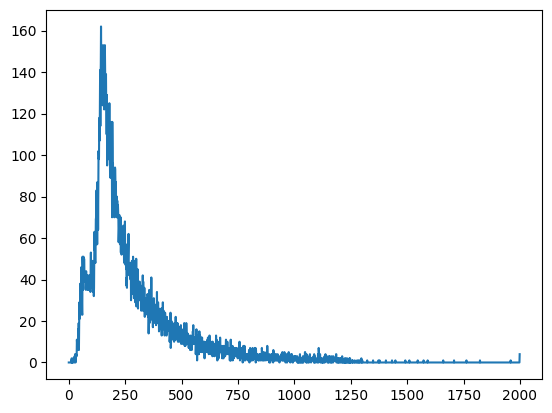

614.0


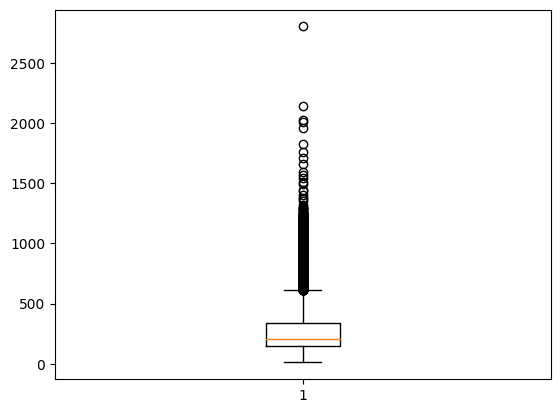

In [6]:
import matplotlib.pyplot as plt

plt.plot(result_train)
plt.show()
# plt.plot(result_test)
# plt.show()
result_reallen_train.sort()
IQR=result_reallen_train[(int)(len(result_reallen_train)*0.75)]-result_reallen_train[(int)(len(result_reallen_train)*0.25)]
fuck=result_reallen_train[(int)(len(result_reallen_train)*0.75)]+1.5*IQR
plt.boxplot(result_reallen_train)
print(fuck)


### 叔叔我啊，要开始训练了捏

首先，写一个获取数据的函数

In [7]:
# from model import MyTransformerEncoder
# import dataset

# model = MyTransformerEncoder()